In [4]:
import torch # pytorch import
import torch.nn as nn # 딥러닝 네트워크 기본 구성요소 포함한 모듈
import torch.nn.functional as F #딥러닝에 자주 사용되는 함수가 포함된 모듈
import torch.optim as optim #가중치 추정에 필요한 최적화 알고리즘을 포함
from torchvision import datasets, transforms # torchvision : 딥러닝에서 자주 사용되는 데이터셋과 모델구조 및 이미지변환 기술 포함

from matplotlib import pyplot as plt #데이터 시각화 모듈 matplotlib에서 pyplot 함수 불러옴
%matplotlib inline 
#주피터노트북 사용자일 경우 코드 실행시 브라우저에서 바로 그림을 보고싶을때 필요한 코드

# 분석환경 설정

In [11]:
is_cuda = torch.cuda.is_available() #false -> cuda gpu 사용 불가

In [12]:
device = torch.device('cuda' if is_cuda else 'cpu')

In [14]:
print('Current cuda device is', device) #GPU 사용 불가하므로 CPU만 사용

Current cuda device is cpu


# HyperParameter 지정

In [16]:
batch_size = 50 #모델 가중치를 한 번 업데이트시킬 때 사용되는 샘플 단위 개수(=미니 배치 사이즈)
epoch_num = 15 #학습 데이터를 모두 사용하여 학습하는 기본 단위 횟수(=epoch수)
learning_rate = 0.0001 #가중치 업데이트의 정도(=학습률)

# MNIST 데이터 불러오기
MNIST데이터는 단일채널이며, [1,28,28]3차원텐서임

In [21]:
train_data = datasets.MNIST(root = './data', train = True, download = True,
                            transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data', train = False,
                           transform = transforms.ToTensor())

#root - MNIST데이터를 저장할 물리적 공간위치. './data' = 현재 폴터 위치의 data라는 폴더 (없으면 생성됌)
#train - 데이터를 학습용으로 사용할 것인지 지정
#download - True를 입력하면 root옵션에서 지정된 위치에 데이터가 저장, 만약 처음 시행이 아니고 이미 저장된 데이터가 있으면 False 입력
#transform - MNIST데이터를 저장과 동시에 전처리를 할 수 있는 옵션 pytorch는 입력데이터로 Tensor를 사용하므로 이미지를 Tensor로 변형하는 전처리 transforms.ToTensor()사용

print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

number of training data :  60000
number of test data :  10000


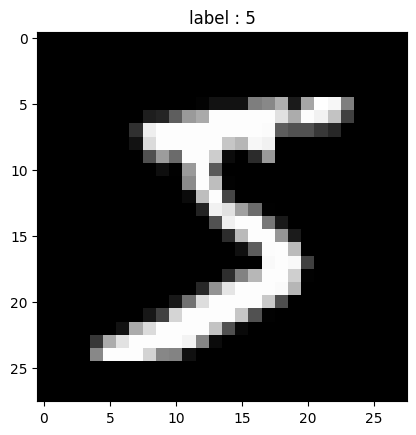

In [31]:
image, label = train_data[0] #첫번째 학습데이터의 입력데이터와 정답을 저장

plt.imshow(image.squeeze().numpy(), cmap = 'gray') #3차원텐서를 2차원으로 줄이기 위해 image.squeeze()를 사용
#squeeze 함수는 크기가 1인 차원을 없애는 함수 [1,28,28] -> [28,28]로 만듦
plt.title('label : %s' %label)
plt.show()

# 미니배치 구성하기

In [34]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True) #shuffle의 경우 시계열 데이터가 아니면 순서학습 못하도록 필수
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)

first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('num of batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
num of batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


60000학습데이터에서 배치사이즈가 50이므로 1200 미니배치 생성

first_batch[0]은 [50,1,28,28]의 4차원텐서임. [batchsize, channel, width, height] (데이터 하나는 3차원이지만 데이터가 쌓여 4차원이됌)

first_batch[1]은 50크기의 벡터. 미니 배치의 정답이 저장된 상태.


# 모델학습

layer를 쌓을 때 핵심은 이전 layer의 출력크기와 직후 layer의 입력크기를 같게 설계해야함.

사용할 CNN구조는 2개의 convolutional layer와 2개의 fully connected layer로 설계함

한개의 텐서가 입력레이어부터 출력레이어까지 어떻게 변할까?

입력 데이터 [channel = 1, width = 28, height = 28]

                  |  ->(conv1 (1,3,3) @ 32)
                  
              [32,26,26]
                  
                  |  ->(conv2 (32,3,3) @ 64)
                  
              [64,24,24]
              
                  |  -> max-pooling
                  
              [64,12,12]
              
                  |  -> Flatten
                  
              [64x12x12]
              
                  |  ->FC1 (9216, 128)
                
                [128]
               
                  |. ->FC2 (128, 10)
                  
            출력 클래스 : [10]
                  

데이터 형태 [], 가중치인 필터형태 (), @ - 필터개수

ex ) conv1 (1,3,3) @ 32 -> filter channel =1, filter width =3, filter height =3 의 필터를 32개 사용

    [1,28,28] -> [32,26,26]된 이유 :
    
    1. 채널의 크기는 필터개수로 결정.
    
    2. 가로세로 크기는 필터사이즈(F), stride 크기(S), padding 크기(P)에 따라 출력되는 feature map의 사이즈(O)공식에 의해 결정
    
        해당 nn.Conv2d함수는 padding = 0, stride = 1을 기본값으로 사용하므로
    
        O = (I + 2P - F)/S +1 = (28 + 2x0 -3)/1 +1 = 26
        
    3. max pooling의 경우 tensor의 가로 세로에만 영향을 주므로 [64,24,24]에서 [64,12,12]로 반감
    
    4. flatten연산은 fully-connected layer연산을 위해 고차원 텐서를 1차원으로 줄이는 것으로 3차원텐서를 9216길이의 1차원 벡터로 변환
    
    5. fc2에서는 각 출력 클래스의 분류확률을 받기 위해 크기를 반드시 맞춰야하며, MNIST는 0~9까지 10개의 클래스이므로 10의 길이로 구성.

In [43]:
class CNN(nn.Module):                             #nn.Module 클래스를 상속받는 CNN 클래스 정의
    def __init__(self):                           #__init__을 통해 모델에서 사용되는 가중치 정의
        super(CNN, self).__init__()               #super함수를 통해 nn.Module클래스의 속성을 상속받고 초기화함
        self.conv1 = nn.Conv2d(1, 32, 3, 1)       #(in_channel = 1, out_channel =32(다음채널 in크기와 같아야함), kernel_size = 3, stride = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)      #kernel_size는 필터의 크기를 나타내며, 스칼라값으로 지정시 가로세로크기가 같은 2d필터 생성됌. 3이면 3x3필터
                                                  #stride는 필터가 움직이는 단위, padding 옵션은 지정하지 않았으므로 기본 패팅값 0이 적용되고 시행되지 않음
        self.dropout1 = nn.Dropout2d(0.25)        #0.25확률의 드롭아웃1 지정
        self.dropout2 = nn.Dropout2d(0.5)         #0.5확률의 드롭아웃2 지정
        self.fc1 = nn.Linear(9216, 128)           # 9216의 크기의 벡터를 128크기의 백터로 변환하는 가중치 설계
        self.fc2 = nn.Linear(128, 10)             # 128크기의 벡터를 10 크기의 벡터로 변환하는 가중치 설계
        
    def forward(self, x) :                        #입력이미지(x)와 정의한 가중치를 이용해 feed forward연산을 정의
        x = self.conv1(x)                         #입력이미지를 conv1 레이어에 통과시킴
        x = F.relu(x)                             #ReLU활성 함수 적용, 활성함수는 단순 연산이므로 __init__에서 정의한 학습 가중치가 없음
        x = self.conv2(x)                         #conv2 레이어 통과
        x = F.relu(x)                             #ReLU활성 함수 적용
        x = F.max_pool2d(x, 2)                    #(2x2)크기의 필터로 maxpooling적용. pooling layer는 단순 연산이므로 학습할 가중치 없음
        x = self.dropout1(x)                      #사전에 정의한 0.25확률의 dropout1반영
        x = torch.flatten(x, 1)                   #고차원 텐서를 1차원 텐서로 변환 64,12,12 3차원 -> 9216 1차원벡터
        x = self.fc1(x)                           #9216크기의 벡터를 128크기의 벡터로 학습하는 fc1통과
        x = F.relu(x)                             #ReLU활성함수 적용
        x = self.dropout2(x)                      #사전에 정의한 0.5확률의 드롭아웃2반영
        x = self.fc2(x)                           #fc2통과하며 128->10으로 줄어듬
        output = F.log_softmax(x, dim = 1)        #최종 출력값으로 log-softmax계산. softmax가아닌 log_softmax()를 사용시 연산속도 높일 수 있음
        return output                             #최종 출력값 반환

# Optimizer 및 손실 함수 정의

In [44]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

CNN클래스를 이용해 model이라는 인스턴스 생성. 이때, 코드 상단에서 지정한 연산 장비(GPU/CPU)인식

손실함수를 최소로하는 가중치를 찾기위해 Adam알고리즘의 optimizer지정

MNIST는 다중 클래스 분류 문제이기에 cross entropy를 손실함수로 설정

# 설계한 CNN모형 확인

In [45]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# 모델학습

In [48]:
model.train()                                    #CNN클래스가 저장된 model인스턴스를 학습모드로 실행할 것 명시
i=0                                              #반복 학습중 손실함수 현황을 확인하고자 학습횟수 나타내는 보조 인텍스 지정
for epoch in range(epoch_num):                   #미리저장해둔 epoch수만큼 반복문 돌림
    for data, target in train_loader:            #학습 데이터를 배치사이즈로 나눈만큼 반복, train_loader는 매 시행시 미니배치의 데이터와 정답을 data와 target에 저장
        data = data.to(device)                   #미니배치의 데이터를 기존에 지정한 device(GPU/CPU)에 할당
        target = target.to(device)               #미니배치의 정답을 기존에 지정한 장비에 할당
        optimizer.zero_grad()                    #학습시작전 이전반복 시행에서 저장된 optimizer의 gradient를 초기화
        output = model(data)                     #미니 배치 데이터를 모델에 통과시키는 feedforward연산으로 결과값 계산
        loss = criterion(output, target)         #계산된 결과값과 실제 정답으로 손실함수 계산
        loss.backward()                          #손실함수를 통해 gradient계산
        optimizer.step()                         #위에서 계산된 gradient를 통해 모델의 가중치 업데이트
        if i % 1000 == 0:                        #학습이 잘되고있는지 확인하고자 1000번째 수행마다 손실함수 확인하기 위한 if문
            print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.item()))          #손실함수 출력
        i += 1                                   #학습을 완료했기때문에 보조인덱스 1올림

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Step: 0	Loss: 2.319
Train Step: 1000	Loss: 0.206
Train Step: 2000	Loss: 0.390
Train Step: 3000	Loss: 0.367
Train Step: 4000	Loss: 0.364
Train Step: 5000	Loss: 0.121
Train Step: 6000	Loss: 0.110
Train Step: 7000	Loss: 0.052
Train Step: 8000	Loss: 0.066
Train Step: 9000	Loss: 0.135
Train Step: 10000	Loss: 0.042
Train Step: 11000	Loss: 0.074
Train Step: 12000	Loss: 0.016
Train Step: 13000	Loss: 0.029
Train Step: 14000	Loss: 0.024
Train Step: 15000	Loss: 0.024
Train Step: 16000	Loss: 0.020
Train Step: 17000	Loss: 0.015


# 모델 평가

In [54]:
model.eval()                                      #eval 함수 호출시 dropout적용되지 않고 batch normalization도 평가모드로 전환됌.
correct = 0                                       #정답개수 저장할 correct를 초기화
for data, target in test_loader :                 #테스트 데이터를 batchsize로 나눈만큼 반복 수행.
    data = data.to(device)                        #미니배치의 데이터를 기존에 지정한 device에 할당
    target = target.to(device)                    #미니배치의 정답을 기존에 지정한 device에 할당
    output = model(data)                          #미니배치 데이터를 모델에 통과시켜 결과값 계산
    prediction = output.data.max(1)[1]            #log-softmax 값이 가장 큰 인덱스를 예측값으로 저장
    correct += prediction.eq(target.data).sum()   #실제 정답과 예측값 같으면 True, 다르면 False로 구성된 벡터를 더함. 즉 미니배치중 정답개수를 구하고 반복시마다 누적하여 합
    
print('Test set: Accuracy: {:.2f}%'.format(100 * correct / len(test_loader.dataset))) #전체 테스트데이터 중 맞춘개수의 비율을 통해 정확도 계산

Test set: Accuracy: 98.96%


정확도의 경우 가중치 초기설정과 dropout등 확률(랜덤)으로 구현되는 부분이 있으므로 매번 동일하게 나올 수 없음.